In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt
%matplotlib inline

In [2]:
sizeAsyCutoff = 50.

In [3]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.93, 2.67e-3, 2.21, 3e-3, 3.86, 6.03e-2, -0.51, 5.57e-2, 0.985, 0.93e-3, 0.633 )
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    # parameters from fitting
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.58, -0.007, 1.03, -0.023, 3.99,  \
#            0.041, -1.63, 0.02, 1.11, 0.006, 0.68 )
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []
dstIndSel = [ -120., -100., -75., -50, -25., -5. ,0. ]
for z in dstIndSel:
    for x in range( -7, 8 ):
        for y in range( -12, 10 ):        
            normLatArr.append( x )
            normMltArr.append( y )
            dstArr.append( z )
            if y > 0:
                mltArr.append( y )
            else:
                mltArr.append( y + 24 )
            latArr.append( x + 57. )
            probSapsArr.append( saps_pred_func(x,y,z) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= 0.05\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,-6,-7,0.089514,18,50.0,-120.0
1,-5,-7,0.162988,19,50.0,-120.0
2,-4,-7,0.223678,20,50.0,-120.0
3,-3,-7,0.231361,21,50.0,-120.0
4,-2,-7,0.180367,22,50.0,-120.0


In [4]:
potDF = feather.read_dataframe('../data/potDF.feather')
potDF.head()

,AsyH,MLAT,normMLT,potential,normLAT,potMagn,mlt
0,45.0,56.5,-7.0,-2.21,-2.0,2.21,17.0
1,45.0,57.0,-7.0,-3.82,-1.5,3.82,17.0
2,45.0,57.5,-7.0,-5.75,-1.0,5.75,17.0
3,45.0,58.5,-7.0,-7.77,0.0,7.77,17.0
4,45.0,59.0,-7.0,-10.10,0.5,10.10,17.0


In [5]:
# Get number of values for different Asy Inds
# discard those values which have low counts
sizeAsyDF = potDF.groupby("AsyH").size().reset_index()
sizeAsyDF.columns = [ "AsyH", "asyCnt" ]
sizeAsyDF = sizeAsyDF[ sizeAsyDF["asyCnt"] >= sizeAsyCutoff]
potDF = pandas.merge(potDF, sizeAsyDF,\
                     on = "AsyH", how="inner"\
                    ).reset_index(drop=True)
# Get peak potentials
peakPotDF = potDF[[ "AsyH", "potMagn" ]].groupby( "AsyH" ).max().reset_index()
peakPotDF.columns = [ "AsyH", "peakPotMagn" ]

In [6]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func( (asy), a_asy, b_asy):
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

poptPeakPot, pcovPeakPot = curve_fit(peak_pot_fit_func,\
                               (peakPotDF['AsyH'].T),\
                               peakPotDF['peakPotMagn'], p0=(1, 0.1))

print list(poptPeakPot)

print "Vpeak = ", str( round(poptPeakPot[0],2) ), "+", str( round(poptPeakPot[1],2) ), "x log(AsyH-index)"

# get pred peak potentials
peakPotDF["predPeakPot"] = [ peak_pot_fit_func(x, *poptPeakPot) for x in peakPotDF["AsyH"] ]

# Normalize the values of potential
# for every AsyH value. This makes 
# fitting easy!
potDF = pandas.merge( potDF, peakPotDF, on="AsyH" )
potDF["normPot"] = potDF["potMagn"]/potDF["peakPotMagn"]

[-6.4658329852118506, 9.4794209905610565]
Vpeak =  -6.47 + 9.48 x log(AsyH-index)


In [7]:
# divide data into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
potDF = pandas.concat( [ potDF, \
                    pandas.cut( potDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
potDF.columns = [ "AsyH", "MLAT", "normMLT", "potential",\
                 "normLAT", "potMagn", "mlt", "asyCnt",\
                 "peakPotMagn", "predPeakPot", "normPot", "AsyH-bin" ]

In [8]:
# To estimate the boundary we
# fit second order harmonics!
def mlt_fit_func((mlt, asy), c1_a, c1_b, s1_a, s1_b,\
                 c2_a, c2_b, s2_a, s2_b, phiC0):
    # Setup the base constants 
    # as functions of Asy index
    c1 = c1_a + c1_b*asy
    s1 = s1_a + s1_b*asy
    c2 = c2_a + c2_b*asy
    s2 = s2_a + s2_b*asy
    phi0 = (2*numpy.pi/24.) * mlt + phiC0
    cosTerm = c1 * numpy.cos(phi0)
    sinTerm = s1 * numpy.sin(phi0)
    cos2Term = c2 * numpy.cos(2*phi0)
    sin2Term = s2 * numpy.sin(2*phi0)
    return cosTerm + sinTerm + cos2Term + sin2Term

In [46]:
potDF["AsyHRnd"] = numpy.round(potDF["AsyH"]/30.)*30.
mltPotDF = potDF[ ["AsyHRnd", "normMLT", "normPot", "mlt"]\
                ].groupby( ["AsyHRnd", "normMLT", "mlt"] \
                ).max().reset_index()
mltPotDF = mltPotDF.dropna()
mltPotDF.head()

maxMLATDF = potDF[ ["AsyHRnd", "normMLT", "MLAT"] ].groupby( ["AsyHRnd", "normMLT"] ).max().reset_index()
normPotVarDF = pandas.merge( potDF, maxMLATDF, on=["AsyHRnd", "normMLT", "MLAT"] ).reset_index(drop=True)

poptNormPot, pcovNormPot = curve_fit(mlt_fit_func,\
                               (mltPotDF['mlt'].T, mltPotDF['AsyHRnd'].T),\
                               mltPotDF['normPot'], p0=(1., 1., 1., 1., 1., 1.,\
                                                          1., 1., 1.))
print poptNormPot
poptNormPot = [ round(x,4) for x in poptNormPot ]
print poptNormPot

predAsyArr = []
predMltArr = []
predNormMltArr = []
predPotArr = []
poptPotArr = []
testInpAsy = 23.
for currAsy in ( numpy.append( mltPotDF["AsyHRnd"].unique() , testInpAsy) ):
    for cpMlt in range(25):
        predMltArr.append( cpMlt )
        predAsyArr.append( currAsy )
        # Fit params
        predPotArr.append( mlt_fit_func(\
                                    (cpMlt, currAsy), *poptNormPot) )
        poptPotArr.append( poptNormPot )
        if cpMlt > 12.:
            normMlt = cpMlt - 24.
        else:
            normMlt = cpMlt
        predNormMltArr.append( normMlt )
    
predPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLT" : predMltArr,
                "predNormMLT" : predNormMltArr,
                "predAsy" : predAsyArr,
                "poptPot" : poptPotArr
                })

[ -7.35286023e-01   2.70479047e-03   1.02620533e+00  -2.33929360e-03
   9.10357918e-02  -2.26419837e-03   1.03579421e-01   1.63902905e-03
  -3.48009265e+00]
[-0.7353, 0.0027, 1.0262, -0.0023, 0.091, -0.0023, 0.1036, 0.0016, -3.4801]


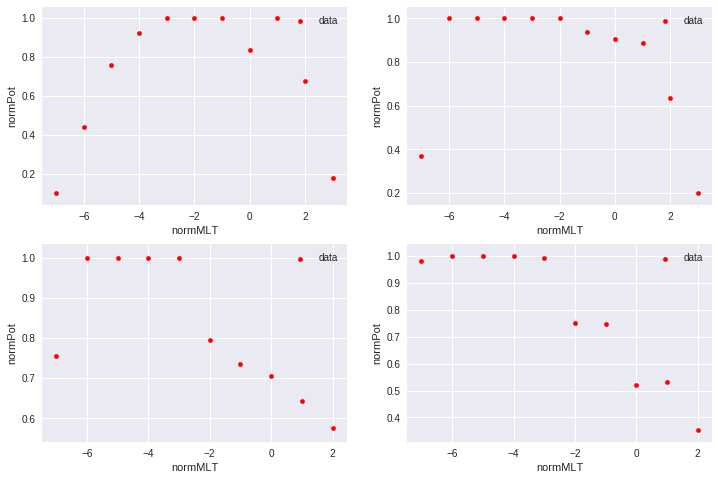

In [54]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

# asyList = [ 0., 40., 80., 120. ]
asyList = [ 0., 30., 60., 90. ]
f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(2,2,1) )
ax.append( f.add_subplot(2,2,2) )
ax.append( f.add_subplot(2,2,3) )
ax.append( f.add_subplot(2,2,4) )
seaMap = ListedColormap(sns.color_palette("Reds"))


for pltInd, pltAsy in enumerate( asyList ):
    pltDF = mltPotDF[ (mltPotDF["AsyHRnd"] == pltAsy) ]
    currNrmPotDF2 = normPotVarDF[ normPotVarDF["AsyHRnd"] == pltAsy ][["AsyHRnd", "normMLT", "normPot", "mlt"]]

    if pltDF.shape[0] > 0.:
        pltDF.plot( x='normMLT',
                    y='normPot', ax=ax[pltInd], c='r', kind="scatter", label="data")
#         sns.pointplot(x="normMLT", y="normPot",
#                  data=currNrmPotDF2, join=False, ax=ax[pltInd])
        
    
        
        
#     pltPredDF = predPotDF[ (predPotDF["predAsy"] == pltAsy) ]
#     pltPredDF.plot( x='predNormMLT',
#                   y='predPot',ax=ax[pltInd], kind="line", c= 'r', label="model")
#     ax[pltInd].set_xlim( [-10, 5] )
#     ax[pltInd].set_ylim( [-0.5, 1.5] )
#     ax[pltInd].text(0.05, 0.9,  "Asy-H : " + str(pltAsy),
#             transform=ax[pltInd].transAxes,
#             color='green', fontsize=14)
#     ax[pltInd].tick_params(labelsize=12)
#     ax[pltInd].set_ylabel("Norm. Potential", fontsize=14)
#     ax[pltInd].set_xlabel("MLT", fontsize=14)
#     ax[pltInd].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
#     ax[pltInd].legend(prop={'size': 12})
plt.savefig("../figs/Pot-MLT-model2.pdf",bbox_inches='tight')

In [11]:
testDF = potDF[ potDF["AsyHRnd"] == 30 ][ ["normMLT", "normPot", "AsyHRnd"] ]
arr = [ testDF[ testDF["normMLT"] == -7. ].values, testDF[ testDF["normMLT"] == -6. ].values,\
       testDF[ testDF["normMLT"] == -5. ].values, testDF[ testDF["normMLT"] == -4. ].values,\
      testDF[ testDF["normMLT"] == -3. ].values, testDF[ testDF["normMLT"] == -2. ].values,\
      testDF[ testDF["normMLT"] == -1. ].values, testDF[ testDF["normMLT"] == 0. ].values,\
      testDF[ testDF["normMLT"] == 1. ].values, testDF[ testDF["normMLT"] == 2. ].values]
# sns.tsplot(arr)


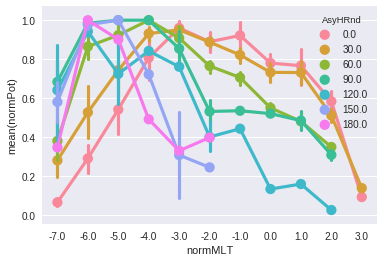

In [36]:
gammas = sns.load_dataset("gammas")
# sns.tsplot(time="timepoint", value="BOLD signal",
#                  unit="subject", condition="ROI",
#                  data=gammas)
maxMLATDF = potDF[ ["AsyHRnd", "normMLT", "MLAT"] ].groupby( ["AsyHRnd", "normMLT"] ).max().reset_index()
testDF = pandas.merge( potDF, maxMLATDF, on=["AsyHRnd", "normMLT", "MLAT"] ).reset_index(drop=True)
sns.pointplot(x="normMLT", y="normPot",
                 hue="AsyHRnd",
                 data=testDF)

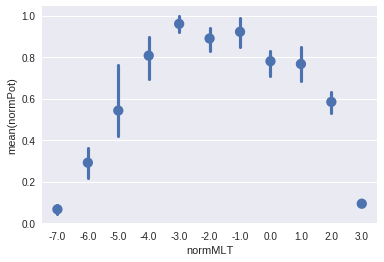

In [45]:
testDF2 = testDF[ testDF["AsyHRnd"] == 0. ][["AsyHRnd", "normMLT", "normPot", "mlt"]]
sns.pointplot(x="normMLT", y="normPot",
                 data=testDF2, join=False)

In [33]:
print xx

[array([ 0.3677457,  0.1951567])
 array([ 0.84689414,  0.58483882,  0.36223636,  1.        ,  0.82791504,
        0.49114754,  0.60798759,  0.36434464,  0.28279619,  0.37647479,
        0.30658337,  0.28158845])
 array([ 0.95304754,  0.87283032,  0.88124054,  0.70739873,  0.90124264,
        0.85128205,  0.79002809,  0.71520343,  0.70987857,  1.        ,
        0.68886199,  0.62855609,  0.92767677,  0.78912564,  0.93317073,
        0.83052434,  0.64393443,  0.82415177,  0.67933307,  0.81617418,
        0.70338164,  0.67277727,  0.59328189,  0.69467286,  0.31172687,
        0.5672058 ,  0.77462758,  0.36946565])
 array([ 1.        ,  1.        ,  0.9897882 ,  1.        ,  0.98037933,
        1.        ,  1.        ,  0.99857245,  1.        ,  0.84482011,
        0.99313963,  0.78636608,  0.95434343,  1.        ,  1.        ,
        1.        ,  0.78918033,  1.        ,  0.91896084,  1.        ,
        0.80434783,  0.95875344,  0.81842941,  1.        ,  0.6952004 ,
        0.85722253,

In [34]:
x = numpy.linspace(0, 15, 31)
data = numpy.sin(x) + numpy.random.rand(10, 31) + numpy.random.randn(10, 1)
print type(data[0])

<type 'numpy.ndarray'>
